In [1262]:
import numpy as np
import numpy as np
import pandas as pd 

from googlemaps import Client as GoogleMaps
import geopy
from geopy.geocoders import Nominatim
import geopandas as gpd

import shapefile as shp

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from rasterio.plot import show

from pyproj import Proj, transform

from utils import * 

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline 

In [1263]:
## useful functions : add docstring and move to utils at end 

def transform_coords(coords,inProj, outProj): 
    x1,y1 = coords[0], coords[1]
    x2,y2 = transform(inProj,outProj,x1,y1)
    return (x2, y2)

def deer_color_num(x): 
    
    "Check that these are the right values!!"
    
    if x=='green':
        return 1.0
    elif x=='yellow':
        return 10.0
    elif x=='white':
        return 23.0
    elif x=='orange':
        return 35.0
    elif x== 'red':
        return 50.0
    
    
def month_map(x):
    if x=='01':
        return 'JAN'
    elif x=='02':
        return 'FEB'
    elif x=='03':
        return 'MAR'
    elif x=='04':
        return 'APR'
    elif x=='05':
        return 'MAY'
    elif x=='06':
        return 'JUN'
    elif x=='07':
        return 'JUL'
    elif x=='08':
        return 'AUG'
    elif x=='09':
        return 'SEP'
    elif x=='10':
        return 'OCT'
    elif x=='11':
        return 'NOV'
    elif x=='12':
        return 'DEC'

## Obtaining and cleaning data  

1. Lyme disease per county per year (https://www.cdc.gov/lyme/datasurveillance/index.html)

2. County locations and shapefile (http://eric.clst.org/tech/usgeojson/)

3. Temperature and precipitation data per month per county (ftp://ftp.ncdc.noaa.gov/pub/data/cirs/climdiv/)

4. Deer population by county (https://data.nal.usda.gov/dataset/white-tailed-deer-density-estimates-across-eastern-united-states-2008)

     - deer_density_QDMA.zip = GIS shapefile depicting white-tailed deer density summarized between 2001 and 2005 by the Quality Deer Management Association for the eastern United States. Categories represent coarse deer density levels as identified in the QDMA report in 2009: (1) rare, absent, or urban area with unknown population, (2) less than 15 deer per square mile, (3) 15 to 30 deer per square mile, (4) 30 to 40 deer per square mile, or (5) greater than 45 deer per square mile. Deer density estimates represent levels summarized between 2001 and 2005 and should not be used to represent current or future deer density levels.

5. Forest cover data 

6. Climate projections for the same resolution in time/space (https://cida.usgs.gov/gdp/client/#!catalog/gdp/dataset/54dd5e4be4b08de9379b38ff)
    - data obtained, need to clean up DFs 
    
7. Add dog data if we can get it : https://capcvet.org/maps/#2017/all/lyme-disease/dog/canada/
8. Need the population per year of counties! 
9. https://www.health.ny.gov/statistics/diseases/communicable/ for NY Lyme numbers 

## Lyme/county data 

In [1372]:
county_shapefile = gpd.read_file("./data/gz_2010_us_050_00_20m/gz_2010_us_050_00_20m.shp")
lyme_per_county = pd.read_csv('./data/LD-Case-Counts-by-County-00-17.csv',encoding='latin-1')

In [1373]:
county_shapefile['long_lat'] = county_shapefile['geometry'].apply(lambda x : list(x.centroid.coords)[0])

In [1374]:
## making the labelling of counties compatible in both files 
## 3,007 counties, 64 parishes, 19 organized boroughs, 10 census areas, 41 independent cities, and the District of Columbia = 3142 total.

county_shapefile['LSAD'] = county_shapefile['LSAD'].replace('CA', 'Census Area') 
county_shapefile['LSAD'] = county_shapefile['LSAD'].replace('Cty&Bor', 'City and Borough') 
county_shapefile['LSAD'] = county_shapefile['LSAD'].replace('Muny', 'Municipality') 
county_shapefile.iloc[777, county_shapefile.columns.get_loc('LSAD')] = ''
county_shapefile.iloc[1107, county_shapefile.columns.get_loc('LSAD')] = ''

county_shapefile['NEWNAME'] = county_shapefile['NAME'] + ' ' + county_shapefile['LSAD']

county_shapefile.COUNTY = county_shapefile.COUNTY.astype('int')
county_shapefile.STATE = county_shapefile.STATE.astype('int')

lyme_per_county = lyme_per_county[lyme_per_county['CTYCODE']!=999]
county_shapefile = county_shapefile[county_shapefile['STATE']!=72]

assert len(lyme_per_county)==len(county_shapefile)
merged = pd.merge(lyme_per_county, county_shapefile,  how='left', left_on=['CTYCODE', 'STCODE'], right_on = ['COUNTY', 'STATE'])
assert len(merged)==len(lyme_per_county)==len(county_shapefile)

In [1375]:
merged[['Ctyname', 'Stname', 'STCODE', 'CTYCODE']].to_csv('./all_county_state.csv')

In [1378]:
lyme_per_county[lyme_per_county['Ctyname'].str.contains('Oglala')]

,Ctyname,Stname,STCODE,CTYCODE,Cases2000,Cases2001,Cases2002,Cases2003,Cases2004,Cases2005,...,Cases2008,Cases2009,Cases2010,Cases2011,Cases2012,Cases2013,Cases2014,Cases2015,Cases2016,Cases2017
2452,Oglala Lakota County,South Dakota,46,102,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [1381]:
county_shapefile.columns

Index(['GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA', 'geometry',
       'long_lat', 'NEWNAME'],
      dtype='object')

In [1387]:
county_shapefile[county_shapefile['NAME'].str.contains('Carson')]

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,long_lat,NEWNAME
764,0500000US08063,8,63,Kit Carson,County,2160.822,"POLYGON ((-102.049806 39.574058, -102.04976383...","(-102.60369538894452, 39.30548760585884)",Kit Carson County
1122,0500000US32510,32,510,Carson City,None,144.662,"POLYGON ((-120.004504420333 39.1655986798664, ...","(-119.74298726381755, 39.15066857645598)",NaN
1150,0500000US48065,48,65,Carson,County,920.220,"POLYGON ((-101.085935 35.619102, -101.086281 3...","(-101.35427989818307, 35.403655700061876)",Carson County


In [1376]:
merged[merged.isna().any(axis=1)]

,Ctyname,Stname,STCODE,CTYCODE,Cases2000,Cases2001,Cases2002,Cases2003,Cases2004,Cases2005,...,Cases2017,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,long_lat,NEWNAME
81,Kusilvak Census Area,Alaska,2,158,0,0,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,District of Columbia,District of Columbia,11,1,11,17,25,14,16,10,...,84,0500000US11001,11.0,1.0,District of Columbia,None,61.048,"POLYGON ((-77.0329858478747 38.839500154093, -...","(-77.01578736260959, 38.90565503863293)",NaN
1763,Carson City,Nevada,32,510,0,1,0,0,0,0,...,2,0500000US32510,32.0,510.0,Carson City,None,144.662,"POLYGON ((-120.004504420333 39.1655986798664, ...","(-119.74298726381755, 39.15066857645598)",NaN
2412,Oglala Lakota County,South Dakota,46,102,0,0,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1388]:
# deleting oglala and all of Alaska 

merged = merged.drop(merged[merged['Stname'] == 'Hawaii'].index)
merged = merged.drop(merged[merged['Stname'] == 'Alaska'].index)
merged = merged.drop(merged[merged['Ctyname'] == 'Oglala Lakota County'].index)

In [1389]:
merged[merged.isna().any(axis=1)]

,Ctyname,Stname,STCODE,CTYCODE,Cases2000,Cases2001,Cases2002,Cases2003,Cases2004,Cases2005,...,Cases2017,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,long_lat,NEWNAME
319,District of Columbia,District of Columbia,11,1,11,17,25,14,16,10,...,84,0500000US11001,11.0,1.0,District of Columbia,None,61.048,"POLYGON ((-77.0329858478747 38.839500154093, -...","(-77.01578736260959, 38.90565503863293)",NaN
1763,Carson City,Nevada,32,510,0,1,0,0,0,0,...,2,0500000US32510,32.0,510.0,Carson City,None,144.662,"POLYGON ((-120.004504420333 39.1655986798664, ...","(-119.74298726381755, 39.15066857645598)",NaN


## Get the temp and precipitation data from the NCDC


ncdc access token : 

> Email:	ag2255@cornell.edu

> Token:	dldkHvyiGcNJRVnZbdOtMneqrLaZmVzK

> links: https://www.ncdc.noaa.gov/cdo-web/webservices/v2#dataCategories


data : ftp://ftp.ncdc.noaa.gov/pub/data/cirs/climdiv/

Instead, just downloaded the smoothed files for each county, 




In [1390]:
colspecs = [[0,2],[2,5],[5,7],[7,11],[11,18],[18,25], [25,32], [32,39],[39,46],[46,53],[53,60],[60,67],[67,74],[74,81],[81,88],[88,95]]
tmax_data = pd.read_fwf('./data/climdiv-tmaxcy-v1.0.0-20190604', index_col=None, colspecs=colspecs, header=None)
tmin_data = pd.read_fwf('./data/climdiv-tmincy-v1.0.0-20190604', index_col=None, colspecs=colspecs, header=None)
tmpc_data = pd.read_fwf('./data/climdiv-tmpccy-v1.0.0-20190604', index_col=None, colspecs=colspecs, header=None)
pcpn_data = pd.read_fwf('./data/climdiv-pcpncy-v1.0.0-20190604', index_col=None, colspecs=colspecs, header=None)

In [1391]:
tmax_data.columns = ['ST', 'DIV', 'EL', 'YR', 'JAN_TMAX', 'FEB_TMAX', 'MAR_TMAX', 'APR_TMAX', 'MAY_TMAX', 'JUN_TMAX', 'JUL_TMAX', 'AUG_TMAX', 'SEP_TMAX', 'OCT_TMAX', 'NOV_TMAX', 'DEC_TMAX']
tmin_data.columns = ['ST', 'DIV', 'EL', 'YR', 'JAN_TMIN', 'FEB_TMIN', 'MAR_TMIN', 'APR_TMIN', 'MAY_TMIN', 'JUN_TMIN', 'JUL_TMIN', 'AUG_TMIN', 'SEP_TMIN', 'OCT_TMIN', 'NOV_TMIN', 'DEC_TMIN']
tmpc_data.columns = ['ST', 'DIV', 'EL', 'YR', 'JAN_TMPC', 'FEB_TMPC', 'MAR_TMPC', 'APR_TMPC', 'MAY_TMPC', 'JUN_TMPC', 'JUL_TMPC', 'AUG_TMPC', 'SEP_TMPC', 'OCT_TMPC', 'NOV_TMPC', 'DEC_TMPC']
pcpn_data.columns = ['ST', 'DIV', 'EL', 'YR', 'JAN_PCPN', 'FEB_PCPN', 'MAR_PCPN', 'APR_PCPN', 'MAY_PCPN', 'JUN_PCPN', 'JUL_PCPN', 'AUG_PCPN', 'SEP_PCPN', 'OCT_PCPN', 'NOV_PCPN', 'DEC_PCPN']

In [1392]:
tmin_data = tmin_data[tmin_data['YR']>=1998]
tmax_data = tmax_data[tmax_data['YR']>=1998]
tmpc_data = tmpc_data[tmpc_data['YR']>=1998]
pcpn_data = pcpn_data[pcpn_data['YR']>=1998]

In [1394]:
stupid_codes = pd.read_csv('./data/state_code_stupid.csv')
logical_codes = pd.read_csv('./data/states_code_logical.csv')
stupid_codes.name = stupid_codes.name.str.lower().str.strip()
logical_codes.name = logical_codes.name.str.lower().str.strip()
stupid_codes.columns=['code','num_stupid','name_stupid']

code_mapping = logical_codes.set_index('name').join(stupid_codes.set_index('name_stupid'))


In [1395]:
# merging all the files together 

tmin_tmax = pd.merge(tmin_data, tmax_data ,how='left', left_on=['ST', 'DIV', 'YR'], right_on = ['ST', 'DIV', 'YR'])
tmin_tmax = tmin_tmax.loc[:,~tmin_tmax.columns.duplicated()]
tmpc_tmin_tmax = pd.merge(tmpc_data, tmin_tmax ,how='left', left_on=['ST', 'DIV', 'YR'], right_on = ['ST', 'DIV', 'YR'])
tmpc_tmin_tmax = tmpc_tmin_tmax.loc[:,~tmpc_tmin_tmax.columns.duplicated()]
pcpn_tmpc_tmin_tmax = pd.merge(pcpn_data, tmpc_tmin_tmax ,how='left', left_on=['ST', 'DIV', 'YR'], right_on = ['ST', 'DIV', 'YR'])
pcpn_tmpc_tmin_tmax = pcpn_tmpc_tmin_tmax.loc[:,~pcpn_tmpc_tmin_tmax.columns.duplicated()]

assert len(pcpn_tmpc_tmin_tmax)==len(tmin_tmax)

pcpn_tmpc_tmin_tmax = pcpn_tmpc_tmin_tmax[pcpn_tmpc_tmin_tmax['ST']!=50]

In [1455]:
def replace_st_code(oldnum):
    new_fips = code_mapping[code_mapping['num']==oldnum]['num_stupid']
    return new_fips.item()

In [1435]:
## replacing the 1-48 numbering by the FIPS codes for the states 
# there's no precipitation/temp data for DC, so we should remove that from merged 

pcpn_tmpc_tmin_tmax['ST_new'] = pcpn_tmpc_tmin_tmax['ST'].apply(lambda x: replace_st_code(x))
merged = merged.drop(merged[merged['STCODE'] == 11].index)


In [1476]:
pcpn_tmpc_tmin_tmax['ST_new'].unique()

array([ 1,  4,  5,  6,  8,  9, 10, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56])

In [1485]:
# exploring how to merge all the data 
finaldf = None

assert len(pcpn_tmpc_tmin_tmax['ST_new'].unique())==len(merged['STCODE'].unique())

for year in range(2000,2018): 
    temp_lyme = merged[['Ctyname','Stname', 'STCODE', 'CTYCODE',  'Cases'+str(year), 'CENSUSAREA', 'geometry','long_lat']]
    temp_tpc = pcpn_tmpc_tmin_tmax[pcpn_tmpc_tmin_tmax['YR']==year]
    temp_merged = pd.merge(temp_lyme, temp_tpc ,how='left', left_on=['STCODE', 'CTYCODE'], right_on = ['ST_new','DIV'])
    temp_merged.rename(columns={'Cases'+str(year): 'Cases'}, inplace=True)
    temp_merged['year'] = int(year)

    if finaldf is None: 
        finaldf = temp_merged
    else:
        finaldf = finaldf.append(temp_merged)

In [1487]:
finaldf.shape

(55926, 66)

In [1488]:

# the weather data is missing a couple of counties from Virginia, so dropping them. 

#pcpn_tmpc_tmin_tmax[pcpn_tmpc_tmin_tmax['DIV']==678]
#pcpn_tmpc_tmin_tmax[pcpn_tmpc_tmin_tmax['DIV']==515]

finaldf = finaldf.dropna(axis=0, how='any')

In [1489]:
finaldf.shape

(55890, 66)

In [1490]:
finaldf[finaldf.isna().any(axis=1)]

,Ctyname,Stname,STCODE,CTYCODE,Cases,CENSUSAREA,geometry,long_lat,ST,DIV,...,AUG_TMAX,SEP_TMAX,OCT_TMAX,NOV_TMAX,DEC_TMAX,ST_new,year,State FIPS Code,County FIPS Code,FIPS


In [1491]:
finaldf['State FIPS Code'] = finaldf['STCODE'].apply(lambda x: str(x).zfill(2))
finaldf['County FIPS Code'] = finaldf['CTYCODE'].apply(lambda x: str(x).zfill(3))
finaldf['FIPS'] = finaldf['State FIPS Code'] + finaldf['County FIPS Code']

In [1492]:
finaldf.to_csv('./lyme_weather.csv')

# 1. Get the forest data from R 

In [746]:
attributes = pd.read_csv('./data/ncld_states/gaplf2011lc_v30_AL/GAP_LANDFIRE_National_Terrestrial_Ecosystems_2011_Attributes.txt',sep='\t')
attr_val = attributes[['Value','NVC_CLASS']]

In [1493]:
finaldf = finaldf.drop(finaldf[finaldf['Stname'] == 'Hawaii'].index)
finaldf = finaldf.drop(finaldf[finaldf['Stname'] == 'Alaska'].index)

In [751]:
list_cols = ['FIPS'] +  list(attr_val.NVC_CLASS.unique())[1:] 
list_fips = finaldf['FIPS'].unique()
coverdf =  pd.DataFrame(columns=list_cols)

for i in range(3105):
    
    ele = list_fips[i]
    forest = pd.read_csv('./data/county_cover/'+str(ele)+'.csv')
    temp = forest.set_index('myclass').join(attr_val.set_index('Value'))
    temp = temp.reset_index()
    temp.columns= ['class', 'index', 'fraction', 'nvc_class']
    temp = temp.groupby('nvc_class').sum()
    temp = temp.reset_index()
    temp = temp.drop(labels=['index', 'class'], axis=1)
    temp.set_index('nvc_class', inplace=True)
    temp = temp.transpose()

    newdf = pd.DataFrame(columns=list_cols)
    for col in newdf.columns[1:]:
        if col in temp.columns:
            newdf[col] = temp[col]
        else:
            newdf[col] = 1e-10
    newdf.index = [0]    
    newdf.at[0,'FIPS'] = ele

    coverdf = coverdf.append(newdf)

In [1494]:
coverdf.head(5)

,FIPS,Forest & Woodland,Shrub & Herb Vegetation,Desert & Semi-Desert,"Polar & High Montane Scrub, Grassland & Barrens",Aquatic Vegetation,Open Rock Vegetation,Nonvascular & Sparse Vascular Rock Vegetation,Agricultural & Developed Vegetation,Introduced & Semi Natural Vegetation,Recently Disturbed or Modified,Open Water,Developed & Other Human Use
0,01001,0.685407,0.231207,0.031586,0.003790,0.000632,0.017688,1.000000e-10,1.895136e-03,6.317119e-04,1.895136e-03,1.000000e-10,1.000000e-10
0,01003,0.524983,0.286790,0.064339,0.015514,0.008898,0.045175,6.160164e-03,8.898015e-03,5.475702e-03,5.932010e-03,5.932010e-03,2.281542e-04
0,01005,0.756405,0.188576,0.014700,0.002940,0.001680,0.007980,1.000000e-10,1.000000e-10,4.199916e-04,2.519950e-03,4.619908e-03,1.000000e-10
0,01007,0.825015,0.149729,0.008419,0.002405,0.000601,0.000601,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10
0,01009,0.373501,0.483724,0.075385,0.010280,0.005140,0.023986,5.711022e-04,1.142204e-03,1.713307e-03,1.142204e-03,1.000000e-10,1.000000e-10


In [753]:
coverdf.to_csv('./data/county_cover_all.csv')

## Load the climate projections

In [814]:
fips_temp = finaldf[finaldf.ST_new==1]['FIPS'].unique()

In [1203]:
file

'CMIPS_ct27.csv'

In [1204]:
list_files = os.listdir('./data/CMIPS_data/')

list_cols = ['YEAR','JAN_PCPN', 'FEB_PCPN', 'MAR_PCPN', 'APR_PCPN', 'MAY_PCPN', 'JUN_PCPN',
       'JUL_PCPN', 'AUG_PCPN', 'SEP_PCPN', 'OCT_PCPN', 'NOV_PCPN', 'DEC_PCPN',
       'JAN_TMPC', 'FEB_TMPC', 'MAR_TMPC', 'APR_TMPC', 'MAY_TMPC',
       'JUN_TMPC', 'JUL_TMPC', 'AUG_TMPC', 'SEP_TMPC', 'OCT_TMPC', 'NOV_TMPC',
       'DEC_TMPC', 'JAN_TMIN', 'FEB_TMIN', 'MAR_TMIN', 'APR_TMIN', 'MAY_TMIN',
       'JUN_TMIN', 'JUL_TMIN', 'AUG_TMIN', 'SEP_TMIN', 'OCT_TMIN', 'NOV_TMIN',
       'DEC_TMIN', 'JAN_TMAX', 'FEB_TMAX', 'MAR_TMAX', 'APR_TMAX', 'MAY_TMAX',
       'JUN_TMAX', 'JUL_TMAX', 'AUG_TMAX', 'SEP_TMAX', 'OCT_TMAX', 'NOV_TMAX',
       'DEC_TMAX','FIPS']

projectiondf =  pd.DataFrame(columns=list_cols)

for file in list_files:
    
    clim = pd.read_csv('./data/CMIPS_data/'+file, skiprows=1, nrows=1440)

    nfips = int((len(clim.columns)-1)/4)
    clim = clim[clim.columns[0:nfips+1]]
    fips = clim.columns[1:]

    prpn_df, tavg_df, tmax_df, tmin_df = clim.iloc[1:361,:],clim.iloc[364:724,:],clim.iloc[727:1087,:],clim.iloc[1090:,:]

    prpn_df['year'] = prpn_df['Unnamed: 0'].apply(lambda x: int(x[0:4]))    
    tavg_df['year'] = tavg_df['Unnamed: 0'].apply(lambda x: int(x[0:4])) 
    tmin_df['year'] = tmin_df['Unnamed: 0'].apply(lambda x: int(x[0:4])) 
    tmax_df['year'] = tmax_df['Unnamed: 0'].apply(lambda x: int(x[0:4])) 

    prpn_df = prpn_df[(prpn_df['year']>=2017) & (prpn_df['year']<=2025)]
    tavg_df = tavg_df[(tavg_df['year']>=2017) & (tavg_df['year']<=2025)]
    tmin_df = tmin_df[(tmin_df['year']>=2017) & (tmin_df['year']<=2025)]
    tmax_df = tmax_df[(tmax_df['year']>=2017) & (tmax_df['year']<=2025)]

    prpn_df['month'] = prpn_df['Unnamed: 0'].apply(lambda x: month_map(x[5:7]))    
    tavg_df['month'] = tavg_df['Unnamed: 0'].apply(lambda x: month_map(x[5:7])) 
    tmin_df['month'] = tmin_df['Unnamed: 0'].apply(lambda x: month_map(x[5:7])) 
    tmax_df['month'] = tmax_df['Unnamed: 0'].apply(lambda x: month_map(x[5:7])) 

    prpn_df['month'] = prpn_df['month'] + '_PCPN'
    tmax_df['month'] = tmax_df['month'] + '_TMAX'
    tmin_df['month'] = tmin_df['month'] + '_TMIN'
    tavg_df['month'] = tavg_df['month'] + '_TMPC'


    for year in prpn_df.year.unique():

        temp = prpn_df[prpn_df['year']==year]
        temp0 = temp.drop(labels=['Unnamed: 0', 'year'], axis=1).set_index(keys='month').transpose()
        temp0['FIPS']  = temp0.index
        temp0 = temp0.reset_index(drop=True)

        temp = tmax_df[tmax_df['year']==year]
        temp1 = temp.drop(labels=['Unnamed: 0', 'year'], axis=1).set_index(keys='month').transpose()
        temp1['FIPS']  = temp1.index
        temp1 = temp1.reset_index(drop=True)

        temp = tavg_df[tavg_df['year']==year]
        temp2 = temp.drop(labels=['Unnamed: 0', 'year'], axis=1).set_index(keys='month').transpose()
        temp2['FIPS']  = temp2.index
        temp2 = temp2.reset_index(drop=True)

        temp = tmin_df[tmin_df['year']==year]
        temp3 = temp.drop(labels=['Unnamed: 0', 'year'], axis=1).set_index(keys='month').transpose()
        temp3['FIPS']  = temp3.index
        temp3 = temp3.reset_index(drop=True)

        merged = temp1.set_index('FIPS').join(temp0.set_index('FIPS')).join(temp2.set_index('FIPS')).join(temp3.set_index('FIPS'))
        merged['YEAR'] = year
        merged['FIPS'] = merged.index
        
        projectiondf = projectiondf.append(merged)

projectiondf['FIPS'] = projectiondf.index
projectiondf.to_csv('./climate_projections.csv')

/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/avani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [1495]:
lyme_weather_cover = finaldf.set_index(keys='FIPS').join(coverdf.set_index(keys='FIPS'))

In [1503]:
# there's 47 values missing from coverdf, which result in 846 missing values/nans for lyme_weather_cover

len(coverdf[coverdf.isna().any(axis=1)])
len(lyme_weather_cover[lyme_weather_cover.isna().any(axis=1)])

In [1505]:
lyme_weather_cover = lyme_weather_cover.dropna(axis=0, how='any')
lyme_weather_cover.to_csv('./lyme_weather_cover.csv')

## Put together with census and NY data 



### Make plots 

In [194]:
output_path = '/Users/avani/Dropbox/Work/dataScience/Insight/PredictLyme/images/'

duration = 0.2 
filenames = [output_path  + x + '_lyme.jpg' for x in dates]
create_gif(filenames, duration)

In [168]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
ax = plt.gca()
im = ax.imshow(np.arange(100).reshape((10,10)))

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.

In [ ]:

data = np.random.rand(6,6)
fig = pl.figure(1)
fig.clf()
ax = fig.add_subplot(1,1,1)
img = ax.imshow(data, interpolation='nearest', vmin=0.5, vmax=0.99)
fig.colorbar(img)

pl.show()

In [171]:
def colorbar(Mappable, Orientation='vertical', Extend='both'):
    Ax = Mappable.axes
    fig = Ax.figure
    divider = make_axes_locatable(Ax)
    Cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(
        mappable=Mappable, 
        cax=Cax,
        use_gridspec=True, 
        extend=Extend,  # mostra um colorbar full resolution de z
        orientation=Orientation
    )

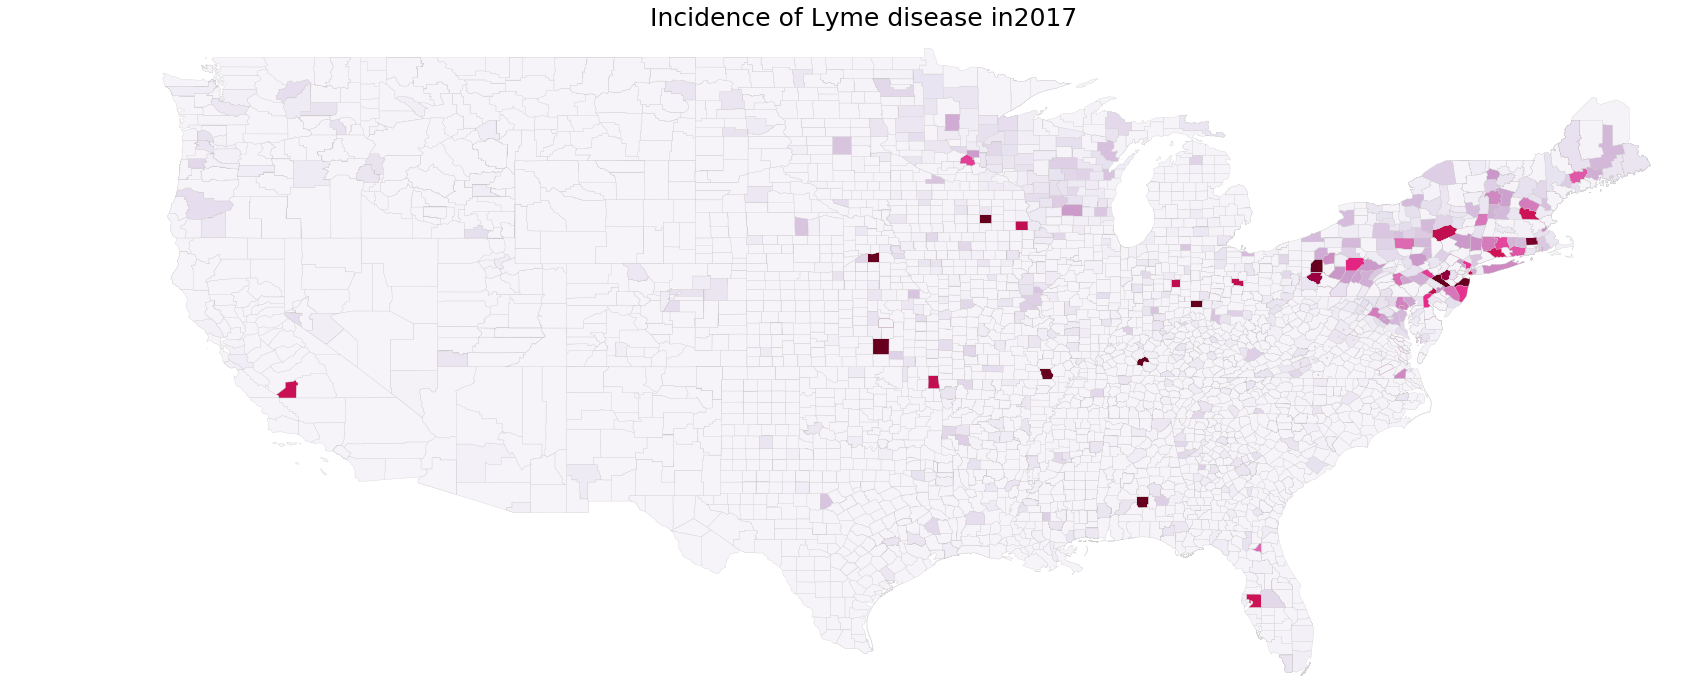

In [196]:
# start the for loop to create one map per year

vmin = 1
vmax = 500

for i in range(17,18):
    
    variable = dates[i]
    # create map, UDPATE: added plt.Normalize to keep the legend range the same for all maps
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(1,1,1)
    merged.plot(column=variable, cmap='PuRd', linewidth=0.3, edgecolor='0.8', vmin=vmin, vmax=vmax, ax = ax)
    #colorbar(ax)                
    ax.set_xlim(-130,-65)
    ax.set_ylim(25,50)
    
    # remove axis of chart
    ax.axis('off')
    
    # add a title
    ax.set_title('Incidence of Lyme disease in ' + str(years[i]), \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # create an annotation for the year by grabbing the first 4 digits
    #only_year = years[i]
    # position the annotation to the bottom left
    #ax.annotate(only_year,
    #        xy=(0.1, .225), xycoords='figure fraction',
    #        horizontalalignment='left', verticalalignment='top',
    #        fontsize=35)
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filepath = os.path.join(output_path, str(variable)+'_lyme.jpg')
    fig.savefig(filepath, dpi=300)

In [6]:
sns.set(style="whitegrid", palette="pastel", color_codes=True) 
sns.mpl.rc("figure", figsize=(10,6))

In [ ]:
## 1. Deer data 

deer_shapefile = gpd.read_file("./data/deer_density_QDMA/deer_density_aea.shp")
deer_shapefile['deer_dnsty'].unique()

# 1) rare, absent, or urban area with unknown population, 
# (2) less than 15 deer per square mile, 
# (3) 15 to 30 deer per square mile, 
# (4) 30 to 40 deer per square mile, or 
# (5) greater than 45 deer per square mile. 

deer_shapefile['deer_dnsty'] = deer_shapefile['deer_dnsty'].apply(lambda x: deer_color_num(x))
inProj = Proj(init=deer_shapefile.crs['init'])
outProj = Proj(init='epsg:4326')

deer_shapefile['geometry_centroids'] = deer_shapefile['geometry'].apply(lambda x: x.centroid.coords[0]) 
deer_shapefile['long_lat'] = deer_shapefile['geometry_centroids'].apply(lambda x: transform_coords(x,inProj, outProj))


merged['deer_density'] = 0

def find_mindist(x0, df): 
    temp = df['long_lat'].apply(lambda x: ((x[0] - x0[0])**2 + (x[1] - x0[1])**2)**0.5)
    return temp.idxmin(), temp[temp.idxmin()]

merged['deer_row'] = 0
merged['deer_dist'] = 0

merged.dropna(inplace=True)
merged = merged.reset_index(drop=True)
# DROP NANS - THERE ARE 54 VALUES THAT HAVE A NAN - will inspect these later 

for i in range(len(merged)): 
    val1 = merged['long_lat'][i]
    idx, dist = find_mindist(val1, deer_shapefile)
    deerval = deer_shapefile['deer_dnsty'][idx]
    merged['deer_row'][i] = idx 
    merged['deer_dist'][i] = dist
    merged['deer_density'][i] = deerval
    
    merged['deer_density'] = merged['long_lat'].apply(lambda x0: find_mindist(x0, deer_shapefile))
    
    # how to check if a point is in a Polygon 

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


for i in range(len(deer_shapefile)): 
    if merged['geometry'][0].contains(Point(deer_shapefile['long_lat'][i])):
        print(deer_shapefile['long_lat'][i], merged['long_lat'][0])
        
point = Point(0.5, 0.5)
polygon = Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])
print(polygon.contains(point))